In [1]:
import time
start_time=time.time()

Abstract

Se presenta un ajuste polinomial (0-6 ord) a los datos observacionales para investigar movimientos a gran escala (detrended data) en direciones X y Y.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

import itertools
from scipy.interpolate import interp1d
from scipy import interpolate

from SABReXX import sosf,acf,psk,ps,sosfnorm,sosfw,sosfw2,sosfs,sosfnorms,sfwh,pst
from CorrPoldef import CPV,CPH
from LRdefX import LR,ACLR
from Pltdef import pltdata

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

Input Data

In [3]:
#Input
#Constant
c=299792.459#km/s
#Iraf
corrhelio=25.68#km/s
#Theory Lambda
lr=[6562.8,6548,6583,6717,6731]#AngstromsR
#lb=[4861.36,4958.9,5006.9]#AngstromsB


n=7

Astronomical Observations

In [4]:
inputf='604.Isis.WHT.Red.txt'

data0=pd.read_table(inputf)
data1=data0.rename(columns={"Center":"Center.0","ErrC":"ErrC.0","Width":"Width.0","ErrW":"ErrW.0","Peak":"Peak.0","ErrP":"ErrP.0",})


In [5]:
#LimitData
min0=85
max0=130
mr=(data1.X<max0)&(data1.X>min0)
data1=data1[mr]

Emission lines data

In [6]:
for i in range(1):
    Nx=i
    N=str(Nx)

    data2=data1[['X','Y','Center.'+N,'Peak.'+N,'Width.'+N]]

    RVo=c*(data2["Center."+N]-lr[Nx])/lr[Nx]
    RV=RVo+corrhelio

    data2=data2.assign(RV=RV.values)

    a=[data2.X,data2.Y,data2.RV,data2['Peak.'+N]]
    data3=pd.DataFrame(a).T
    data3.columns=['X','Y','RV','I']
    data3.to_csv('dataI'+str(int(lr[Nx]))+'.csv')

# Muestra (i) H alfa

In [7]:
datap='dataI6562.csv'
dt=pd.read_csv(datap)
dt=dt.rename(columns={'Unnamed: 0':'No'})
dt=dt.drop('No',axis=1)
os.remove(datap)
dt.describe()

,X,Y,RV,I
count,330.000000,330.000000,330.000000,330.00000
mean,107.280606,9.390000,-250.078110,3790.96303
std,12.788100,6.260324,9.698000,4506.06462
min,85.820000,0.000000,-270.969636,226.00000
25%,96.550000,4.000000,-256.934280,1275.25000
50%,107.280000,9.000000,-250.390538,2168.50000
75%,118.010000,15.000000,-244.714727,4462.00000
max,128.740000,19.600000,-205.463695,30960.00000


In [8]:
wd=dt.X.max()-dt.X.min()
hd=dt.Y.max()-dt.Y.min()
ar=wd/hd
sz=4

Statistical Data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


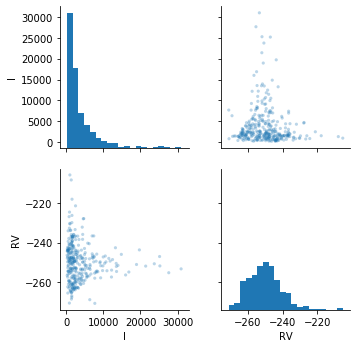

In [9]:
sns.pairplot(dt, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )


Emission Map

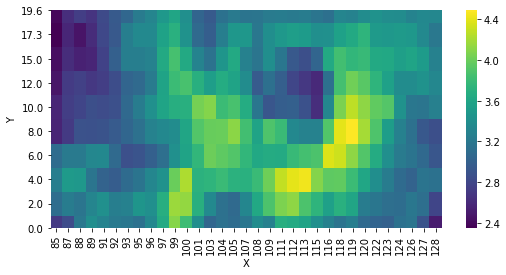

In [10]:
datal=dt.copy()
datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
#datal.Y=datal.Y.astype(int)

dataH_f=(datal.round(2)).pivot(index='Y', columns='X', values='I')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_f, cmap="viridis",xticklabels='auto')
plt.gca().invert_yaxis()
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')


plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="16"

Radial Velocity

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


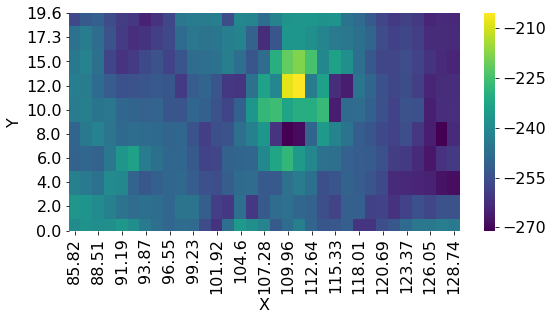

In [11]:
datal=dt.copy()
dataH_rv=(datal.round(2)).pivot(index='Y', columns='X', values='RV')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

Weighted property

In [12]:
W=np.log(abs((dt.RV*dt.I)/dt.I.sum()))
W.head()

0   -0.786247
1   -0.744382
2   -0.849627
3   -0.694816
4   -0.673892
dtype: float64

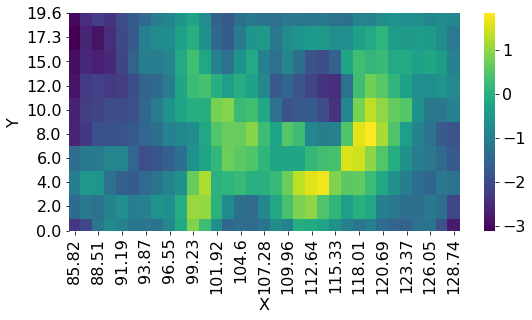

In [13]:
dtW=[dt.X,dt.Y,W]
dtW=pd.DataFrame(dtW).T
dtW.columns=['X','Y','W']

dtH_W=(dtW.round(2)).pivot(index='Y', columns='X', values='W')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dtH_W, cmap="viridis")
plt.gca().invert_yaxis()


Horizontal Polynomial Correction

 
-250.1
 
-0.2249 x - 226
          2
-0.02023 x + 4.116 x - 455.5
          3          2
-0.00177 x + 0.5493 x - 56.46 x + 1674
          4           3         2
0.000116 x - 0.05156 x + 8.513 x - 619.1 x + 1.649e+04
           5            4         3         2
9.697e-06 x - 0.005085 x + 1.059 x - 109.5 x + 5623 x - 1.149e+05
            6             5           4         3         2
-3.668e-07 x + 0.0002458 x - 0.06816 x + 10.01 x - 821.6 x + 3.571e+04 x - 6.424e+05


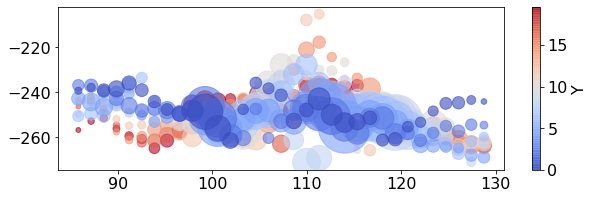

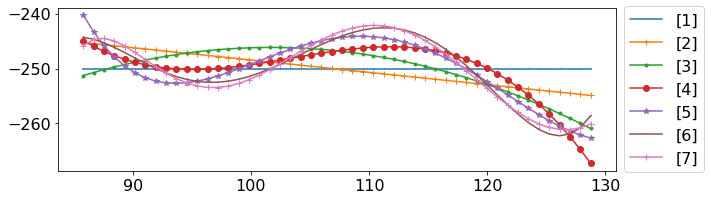

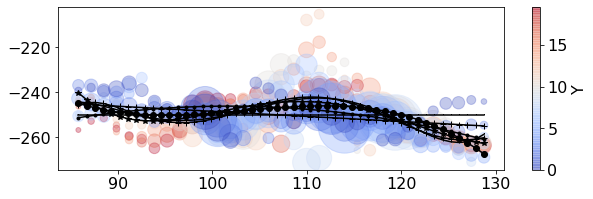

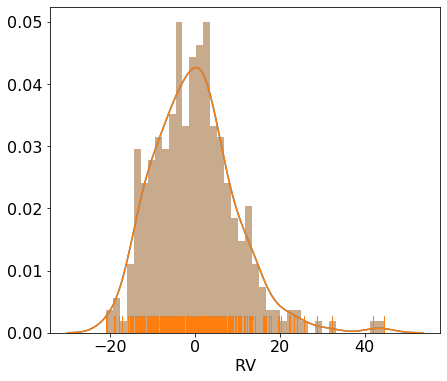

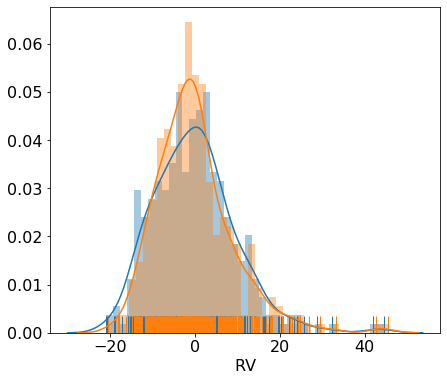

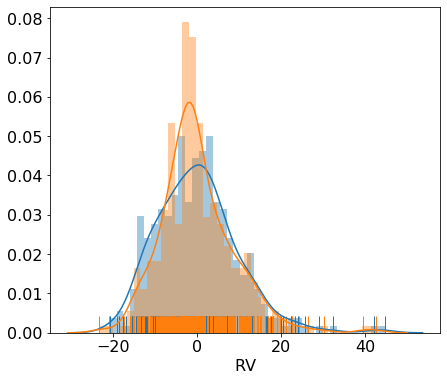

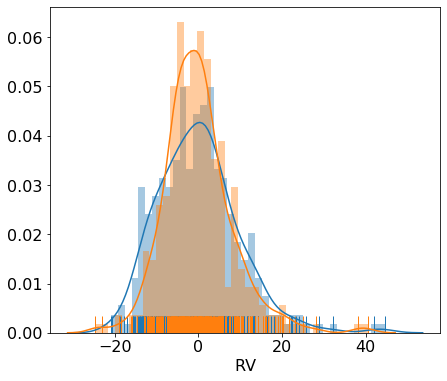

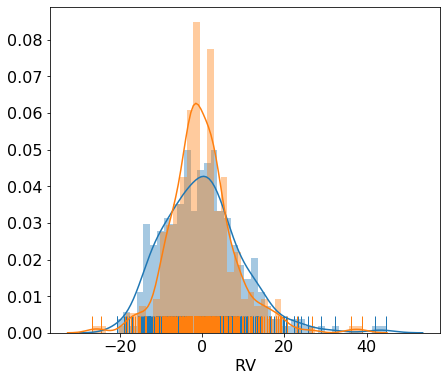

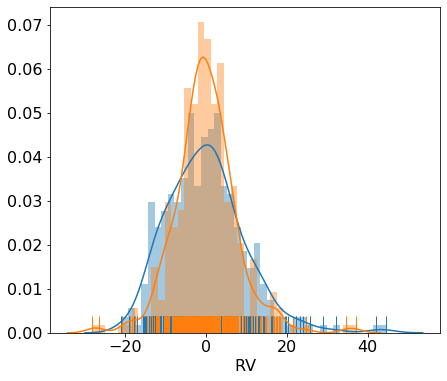

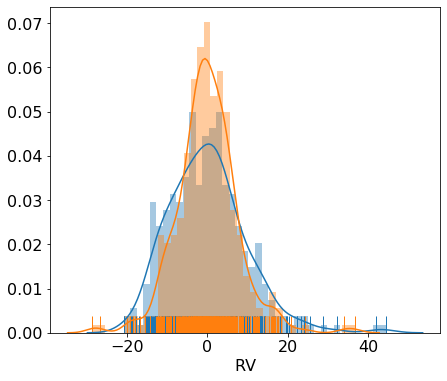

In [14]:
argo1=CPH(dt,n)

Vertical Polynomial Correction

 
-250.1
 
-0.02755 x - 249.8
          2
0.004187 x - 0.1097 x - 249.6
           3          2
-0.006441 x + 0.1921 x - 1.486 x - 247.9
           4           3          2
0.0006683 x - 0.03256 x + 0.5105 x - 2.726 x - 247.3
            5             4           3          2
-1.789e-06 x + 0.0007557 x - 0.03405 x + 0.5208 x - 2.75 x - 247.2
           6            5           4          3         2
2.195e-05 x - 0.001279 x + 0.02855 x - 0.3119 x + 1.766 x - 4.704 x - 247.1


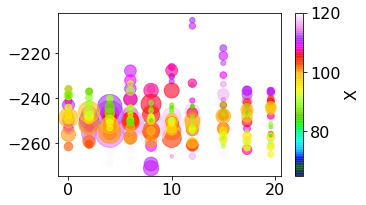

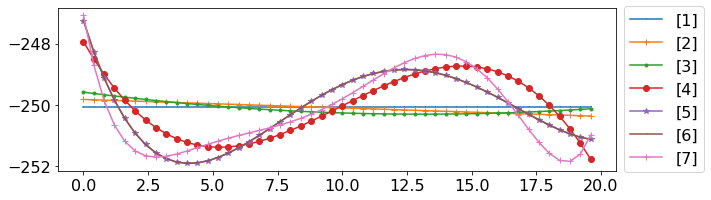

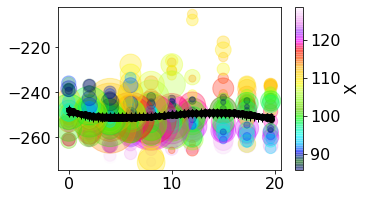

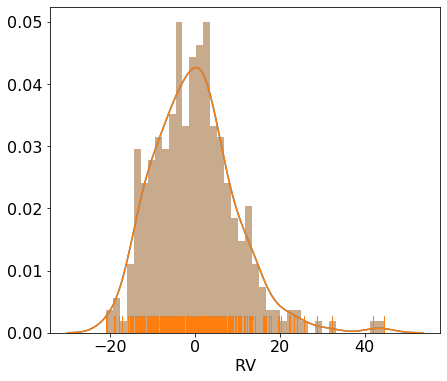

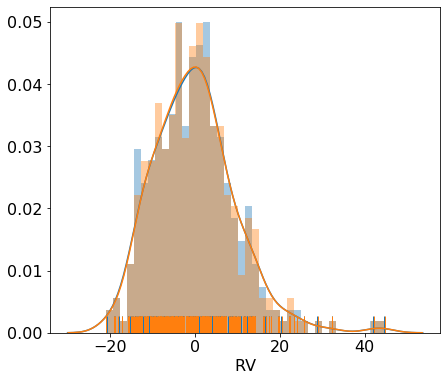

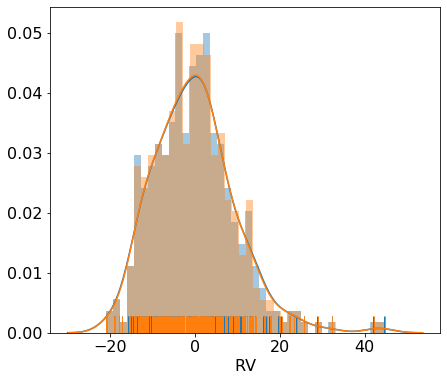

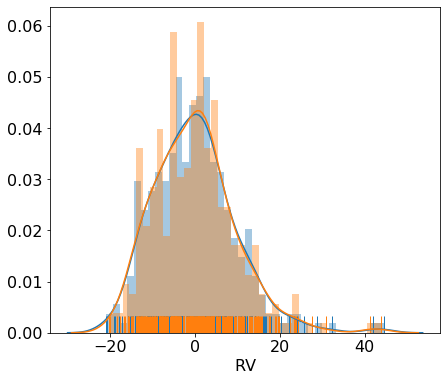

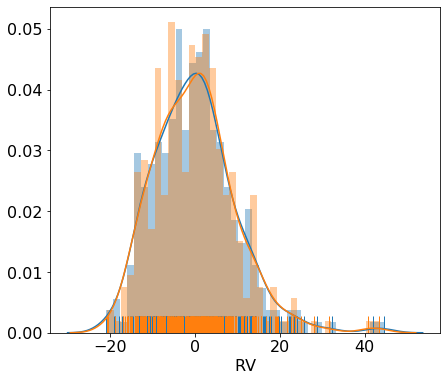

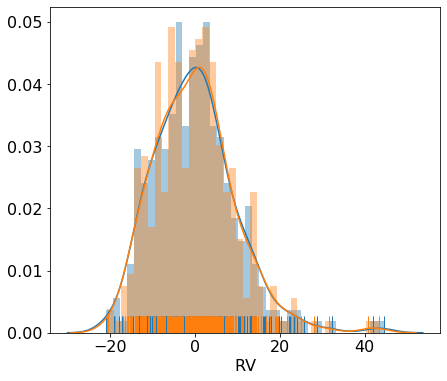

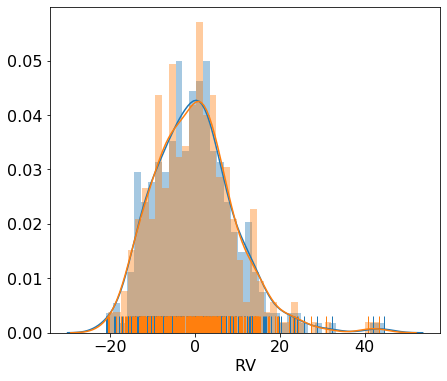

In [15]:
argo2=CPV(dt,n)

Structure Function

In [16]:
SF1=dict()

for i in range(n):
    SF1[i]=sosf(argo1[i])
    
SF2=dict()

for i in range(n):
    SF2[i]=sosf(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [17]:
xi=1
xf=12

SF1Data=dict()
SF1Pr=dict()

for i in range(n):
    SF1Data[i],SF1Pr[i]=LR(SF1[i]['Lag'],SF1[i]['Nmqvd'],SF1[i]['ErrY'],xi,xf,n)
    
SF2Data=dict()
SF2Pr=dict()


for i in range(n):
    SF2Data,SF2Pr[i]=LR(SF2[i]['Lag'],SF2[i]['Nmqvd'],SF2[i]['ErrY'],xi,xf,n)

In [18]:
SF1Data,SF2Data

({0:               R        eps     alpha    lags
  Value  0.991013  48.408835  0.587444   2.667
  Err    0.000838   1.714582  0.010411  16.037,
  1:               R       eps     alpha    lags
  Value  0.990891  49.32484  0.566492   2.667
  Err    0.000870   1.75759  0.010427  16.037,
  2:               R        eps     alpha    lags
  Value  0.985675  54.084517  0.502810   2.667
  Err    0.000591   1.939668  0.010574  16.037,
  3:               R        eps     alpha    lags
  Value  0.949811  62.999959  0.396375   2.667
  Err    0.001230   2.226466  0.010217  16.037,
  4:               R        eps     alpha    lags
  Value  0.932883  67.061283  0.343200   2.667
  Err    0.002255   2.385703  0.010348  16.037,
  5:               R        eps     alpha    lags
  Value  0.898647  70.664373  0.289031   2.667
  Err    0.004618   2.558877  0.010564  16.037,
  6:               R        eps     alpha    lags
  Value  0.902562  70.488507  0.286020   2.667
  Err    0.004734   2.564730  0.0106

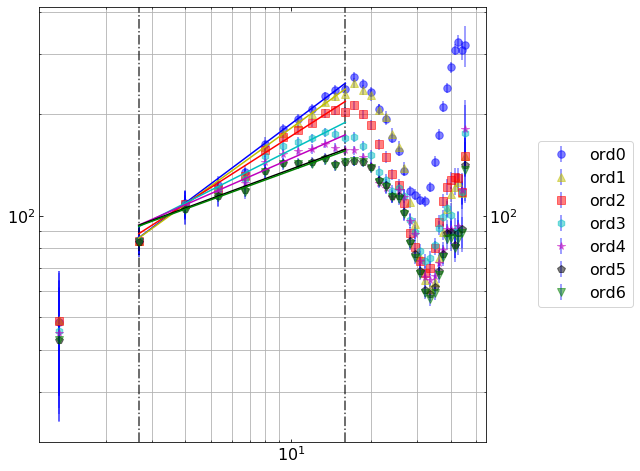

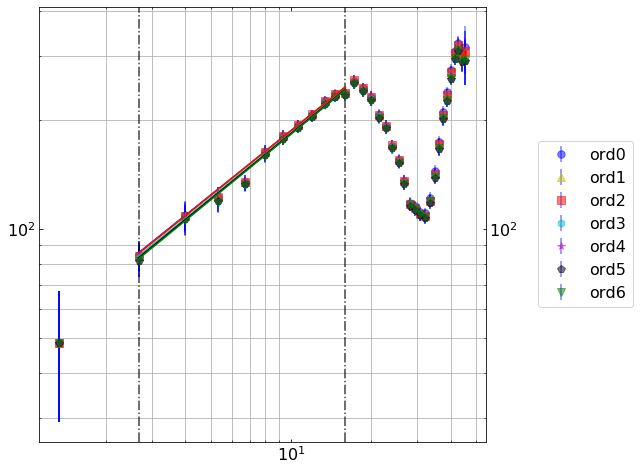

In [19]:
pltdata(SF1,SF1Pr,xi,xf,n)
pltdata(SF2,SF2Pr,xi,xf,n)

Structure Function Norm

In [20]:
SFn1=dict()

for i in range(n):
    SFn1[i]=sosfnorm(argo1[i])
    
SFn2=dict()

for i in range(n):
    SFn2[i]=sosfnorm(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:695: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:704: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [21]:
xi=1
xf=12

SFN1Data=dict()
SFN1Pr=dict()

for i in range(n):
    SFN1Data[i],SFN1Pr[i]=LR(SFn1[i]['Lag'],SFn1[i]['Nmqvd'],SFn1[i]['ErrY'],xi,xf,n)
    
SFN2Data=dict()
SFN2Pr=dict()

for i in range(n):
    SFN2Data[i],SFN2Pr[i]=LR(SFn2[i]['Lag'],SFn2[i]['Nmqvd'],SFn2[i]['ErrY'],xi,xf,n)

In [22]:
SFN1Data,SFN2Data

({0:               R       eps     alpha    lags
  Value  0.991058  0.516288  0.587454   2.667
  Err    0.000826  0.018283  0.010405  16.037,
  1:               R       eps     alpha    lags
  Value  0.990908  0.576949  0.566336   2.667
  Err    0.000868  0.020590  0.010449  16.037,
  2:               R       eps     alpha    lags
  Value  0.985665  0.703867  0.502807   2.667
  Err    0.000592  0.025343  0.010633  16.037,
  3:               R       eps     alpha    lags
  Value  0.949746  0.919087  0.396392   2.667
  Err    0.001288  0.032465  0.010207  16.037,
  4:               R       eps     alpha    lags
  Value  0.933013  1.045166  0.343154   2.667
  Err    0.002236  0.037132  0.010330  16.037,
  5:               R       eps     alpha    lags
  Value  0.898323  1.168973  0.288809   2.667
  Err    0.004714  0.042461  0.010614  16.037,
  6:               R       eps     alpha    lags
  Value  0.902495  1.177361  0.286187   2.667
  Err    0.004714  0.042776  0.010640  16.037},
 {0: 

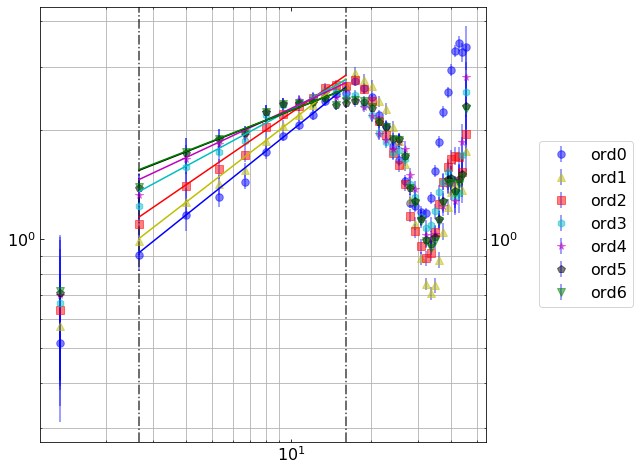

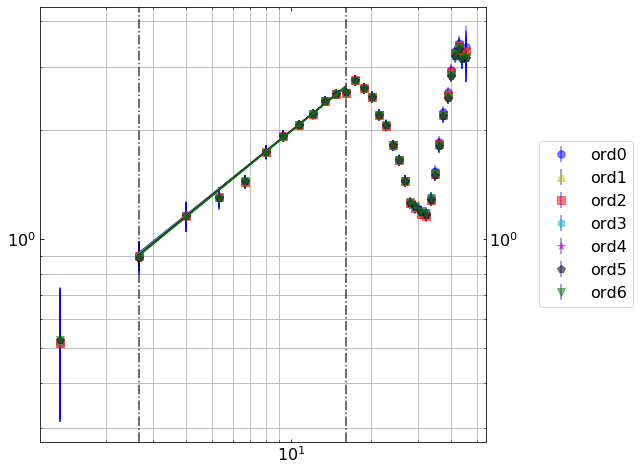

In [23]:
pltdata(SFn1,SFN1Pr,xi,xf,n)
pltdata(SFn2,SFN2Pr,xi,xf,n)

Weighted Structure Function

In [24]:
SFw1=dict()

for i in range(n):
    SFw1[i]=sosfw(argo1[i])

SFw2=dict()

for i in range(n):
    SFw2[i]=sosfw(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1171: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1180: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [25]:
xi=1
xf=8

SFW1Data=dict()
SFW1Pr=dict()


for i in range(n):
    SFW1Data[i],SFW1Pr[i]=LR(SFw1[i]['Lag'],SFw1[i]['Nmqvd'],SFw1[i]['ErrY'],xi,xf,n)
    
SFW2Data=dict()
SFW2Pr=dict()


for i in range(n):
    SFW2Data[i],SFW2Pr[i]=LR(SFw2[i]['Lag'],SFw2[i]['Nmqvd'],SFw2[i]['ErrY'],xi,xf,n)

In [26]:
SFW1Data,SFW2Data

({0:               R       eps     alpha    lags
  Value  0.869068  8.844928  0.396567   2.667
  Err    0.018057  0.462128  0.016758  10.668,
  1:               R       eps     alpha    lags
  Value  0.865579  9.737238  0.378293   2.667
  Err    0.018535  0.506363  0.016448  10.668,
  2:               R        eps     alpha    lags
  Value  0.830469  11.252558  0.328225   2.667
  Err    0.023383   0.579442  0.015723  10.668,
  3:               R        eps     alpha    lags
  Value  0.779253  13.111069  0.297009   2.667
  Err    0.031543   0.687117  0.016082  10.668,
  4:               R        eps     alpha    lags
  Value  0.793766  14.190409  0.279318   2.667
  Err    0.029294   0.718291  0.014814  10.668,
  5:               R        eps     alpha    lags
  Value  0.831194  14.721102  0.298881   2.667
  Err    0.023678   0.738022  0.014136  10.668,
  6:               R        eps     alpha    lags
  Value  0.848916  14.731591  0.303176   2.667
  Err    0.020706   0.725191  0.013480 

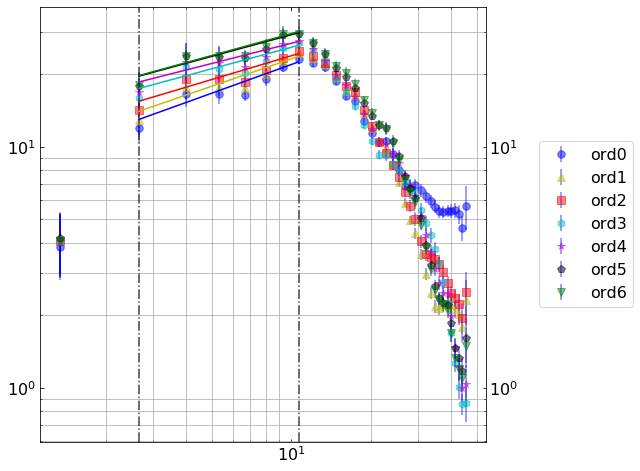

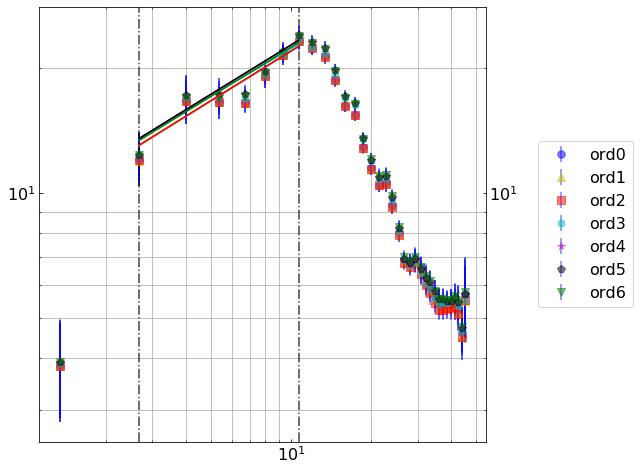

In [27]:
pltdata(SFw1,SFW1Pr,xi,xf,n)
pltdata(SFw2,SFW2Pr,xi,xf,n)

Weighted Property

In [28]:
SFwII1=dict()

for i in range(n):
    SFwII1[i]=sosfw2(argo1[i])
    
SFwII2=dict()

for i in range(n):
    SFwII2[i]=sosfw2(argo1[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1651: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1660: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [29]:
xi=1
xf=11

SFWII1Data=dict()
SFWII1Pr=dict()

for i in range(n):
    SFWII1Data[i],SFWII1Pr[i]=LR(SFwII1[i]['Lag'],SFwII1[i]['Nmqvd'],SFwII1[i]['ErrY'],xi,xf,n)
    
SFWII2Data=dict()
SFWII2Pr=dict()

for i in range(n):
    SFWII2Data[i],SFWII2Pr[i]=LR(SFwII2[i]['Lag'],SFwII2[i]['Nmqvd'],SFwII2[i]['ErrY'],xi,xf,n)

In [30]:
SFWII1Data,SFWII2Data

({0:               R       eps     alpha    lags
  Value  0.884734  1.438977  0.225474   2.667
  Err    0.019585  0.066852  0.014628  14.692,
  1:               R       eps     alpha    lags
  Value  0.861626  1.515029  0.219895   2.667
  Err    0.022468  0.071581  0.014877  14.692,
  2:               R       eps     alpha    lags
  Value  0.895032  1.562320  0.215982   2.667
  Err    0.019770  0.075405  0.014895  14.692,
  3:               R       eps     alpha    lags
  Value  0.800437  1.745246  0.165518   2.667
  Err    0.030672  0.084705  0.014187  14.692,
  4:               R       eps     alpha    lags
  Value  0.819180  1.858091  0.136744   2.667
  Err    0.044459  0.093302  0.014164  14.692,
  5:               R       eps     alpha    lags
  Value  0.863047  1.821618  0.137947   2.667
  Err    0.038241  0.094447  0.013524  14.692,
  6:               R      eps     alpha    lags
  Value  0.852999  1.83160  0.135667   2.667
  Err    0.041988  0.09464  0.013526  14.692},
 {0:    

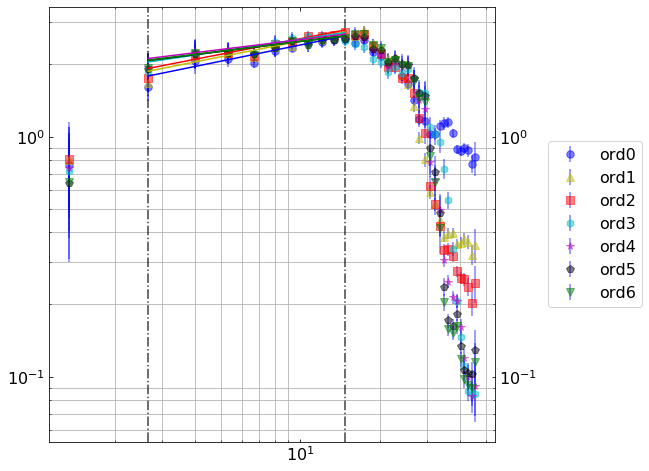

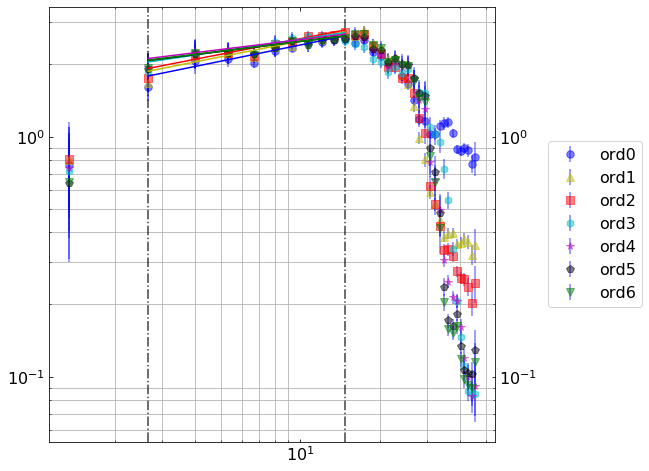

In [31]:
pltdata(SFwII1,SFWII1Pr,xi,xf,n)
pltdata(SFwII2,SFWII2Pr,xi,xf,n)

Structure Function Dr. Will

In [32]:
SFwh1=dict()

for i in range(n):
    SFwh1[i]=sfwh(argo1[i])
    
SFwh2=dict()

for i in range(n):
    SFwh2[i]=sfwh(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [33]:
xi=1
xf=16

SFwh1Data=dict()
SFwh1Pr=dict()

for i in range(n):
    SFwh1Data[i],SFwh1Pr[i]=LR(SFwh1[i]['Lag'],SFwh1[i]['Nmqvd'],SFwh1[i]['ErrY'],xi,xf,n)
    
SFwh2Data=dict()
SFwh2Pr=dict()

for i in range(n):
    SFwh2Data[i],SFwh2Pr[i]=LR(SFwh2[i]['Lag'],SFwh2[i]['Nmqvd'],SFwh2[i]['ErrY'],xi,xf,n)

In [34]:
SFwh1Data,SFwh2Data

({0:               R        eps     alpha    lags
  Value  0.826543  43.302515  0.666254   4.304
  Err    0.004183   1.473686  0.005720  12.810,
  1:               R        eps     alpha    lags
  Value  0.814971  42.995995  0.660331   4.304
  Err    0.003825   1.490876  0.005588  12.810,
  2:               R        eps     alpha    lags
  Value  0.826490  45.976755  0.628083   4.304
  Err    0.004836   1.625192  0.006130  12.810,
  3:               R        eps     alpha    lags
  Value  0.717549  53.257609  0.488695   4.304
  Err    0.007389   1.869072  0.005454  12.810,
  4:               R        eps     alpha    lags
  Value  0.723515  55.240058  0.454358   4.304
  Err    0.009111   2.007536  0.005890  12.810,
  5:               R        eps     alpha    lags
  Value  0.575617  65.086844  0.341652   4.304
  Err    0.012008   2.348444  0.005868  12.810,
  6:               R        eps     alpha    lags
  Value  0.581477  64.198635  0.342270   4.304
  Err    0.012439   2.342072  0.0

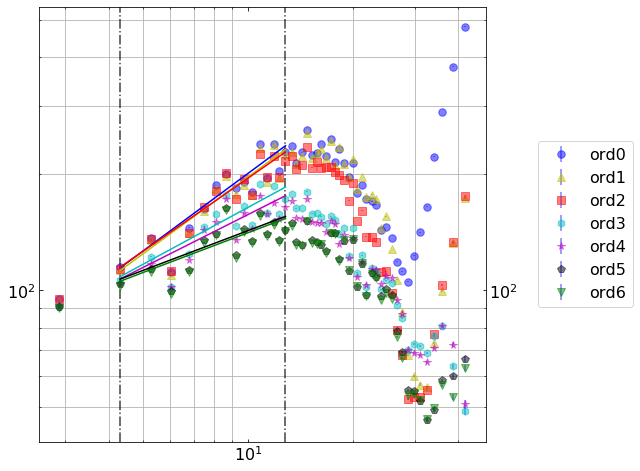

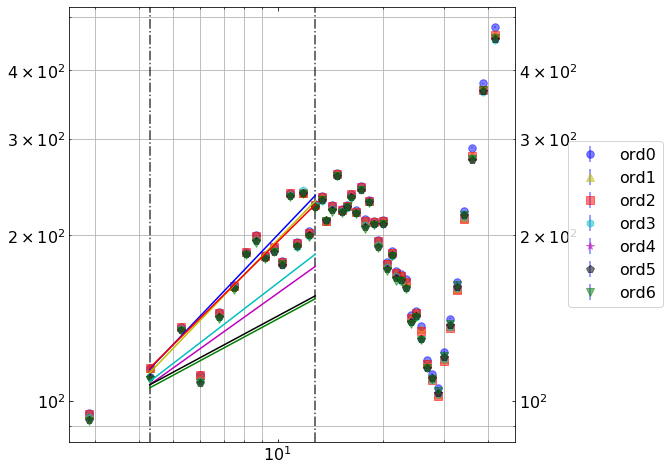

In [35]:
pltdata(SFwh1,SFwh1Pr,xi,xf,n)
pltdata(SFwh2,SFwh1Pr,xi,xf,n)

Autocorrelation Function

In [36]:
AF1=dict()

for i in range(n):
    AF1[i]=acf(argo1[i])
    
AF2=dict()

for i in range(n):
    AF2[i]=acf(argo2[i])

In [37]:
AF1Data=dict()
AF1Inter=dict()


for i in range(n):

    AF1Data[i],AF1Inter[i]=ACLR(AF1[i])
    
AF2Data=dict()
AF2Inter=dict()


for i in range(n):

    AF2Data[i],AF2Inter[i]=ACLR(AF2[i])
    

AF1Data,AF2Data 

({0: array([11.46473967, 23.24465183, 34.94401618]),
  1: array([11.4548524 , 25.54728699, 39.33186207]),
  2: array([ 9.87186511, 22.08327376, 35.80887875]),
  3: array([ 8.03751344, 20.06313797, 35.08694312, 42.04912196, 44.3456212 ]),
  4: array([ 7.81247475, 19.84768595, 25.76649813, 29.88032041, 38.46700708]),
  5: array([ 7.7364915 , 21.12998153, 21.9508915 , 22.92595891, 25.45641671,
         26.00816567, 37.89932017]),
  6: array([ 7.74987646, 21.21552737, 22.04929465, 22.85907962, 37.7657703 ])},
 {0: array([11.46473967, 23.24465183, 34.94401618]),
  1: array([11.47252394, 23.26167967, 34.94912433]),
  2: array([11.46996959, 23.27436517, 34.94848051]),
  3: array([11.46348156, 23.28463302, 34.92463802]),
  4: array([11.45604672, 23.28691426, 34.90809452]),
  5: array([11.45584388, 23.2869363 , 34.90821392]),
  6: array([11.44821656, 23.28563091, 34.90723684])})

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


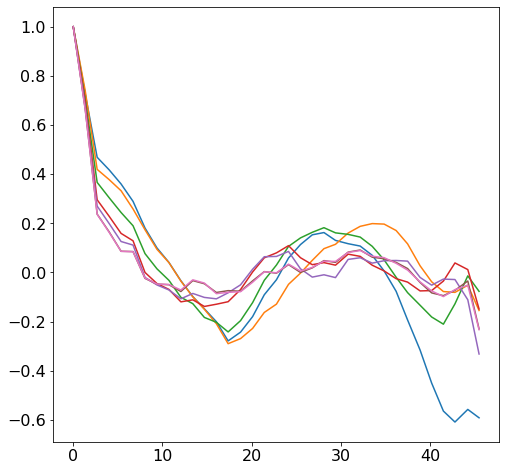

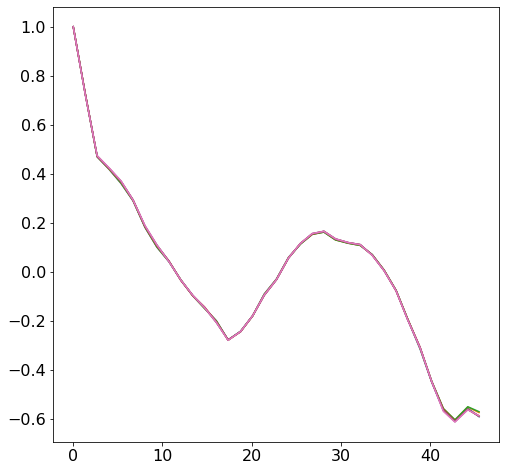

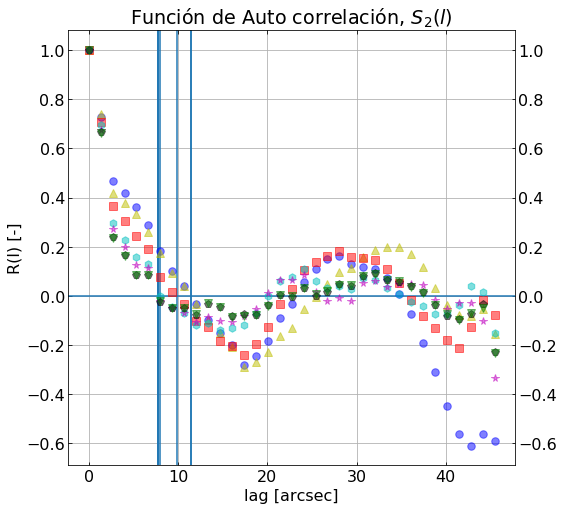

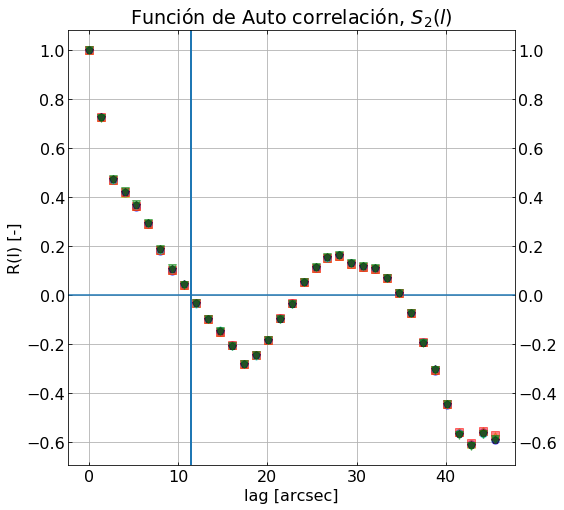

In [38]:
fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    plt.plot(AF1[i]['Lag'],AF1[i]['Nmqvd'])

fig, ax=plt.subplots(figsize=(8,8))
    
for i in range(n):
    plt.plot(AF2[i]['Lag'],AF2[i]['Nmqvd'])
    
marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF1Inter[i][0],AF1Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF1Data[y][i])



marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF2Inter[i][0],AF2Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF2Data[y][i])

1DPSD

In [39]:
PS1=dict()

for i in range(n):
    PS1[i]=ps(argo1[i])
    
PS2=dict()

for i in range(n):
    PS2[i]=ps(argo2[i])

In [40]:
xi=1
xf=10

PS1Data=dict()
mx=len(PS1[i]['k'])
PS1Pr=dict()

for i in range(n):
    PS1Data[i],PS1Pr[i]=LR(PS1[i]['k'][1:mx],PS1[i]['Pk'][1:mx],PS1[i]['Err'][1:mx],xi,xf,n)
    
PS2Data=dict()
PS2Pr=dict()

for i in range(n):
    PS2Data[i],PS2Pr[i]=LR(PS2[i]['k'][1:mx],PS2[i]['Pk'][1:mx],PS2[i]['Err'][1:mx],xi,xf,n)

In [41]:
PS1Data,PS2Data

({0:               R            eps     alpha  lags
  Value  0.839830  585548.162403 -1.968608   1.0
  Err    0.003119   33756.909981  0.004360   9.0,
  1:               R            eps     alpha  lags
  Value  0.813643  436228.629694 -1.849372   1.0
  Err    0.005378   16725.922058  0.012453   9.0,
  2:               R            eps     alpha  lags
  Value  0.829933  486371.399386 -1.903011   1.0
  Err    0.004780   21189.418552  0.009961   9.0,
  3:               R            eps     alpha  lags
  Value  0.840190  360770.174252 -1.728313   1.0
  Err    0.010366    9267.546825  0.017908   9.0,
  4:               R            eps     alpha  lags
  Value  0.780971  280118.623623 -1.601606   1.0
  Err    0.006712    1801.772669  0.026686   9.0,
  5:               R            eps     alpha  lags
  Value  0.688679  237820.223893 -1.541306   1.0
  Err    0.001883     421.263446  0.029824   9.0,
  6:               R            eps     alpha  lags
  Value  0.691651  230253.812340 -1.522052

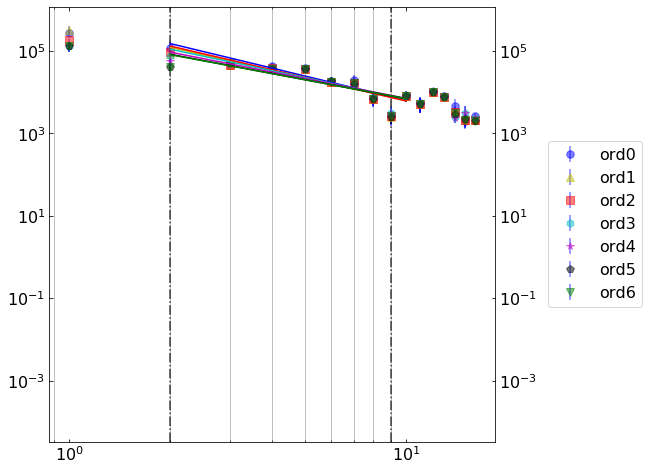

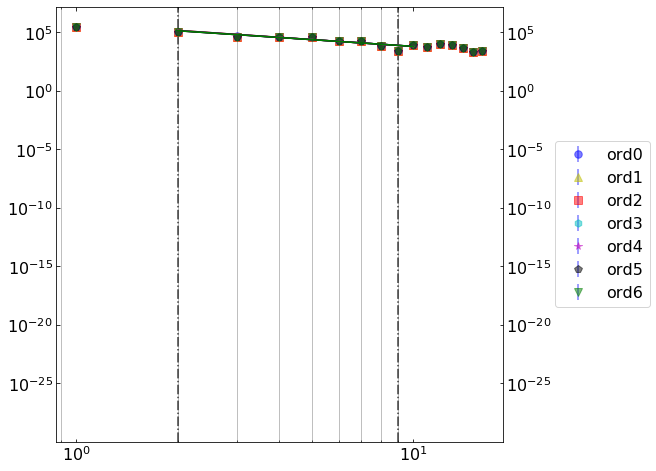

In [42]:
pltdata(PS1,PS1Pr,xi+1,xf,n)
pltdata(PS2,PS2Pr,xi+1,xf,n)

In [43]:
PS1k=dict()

for i in range(n):
    PS1k[i]=psk(argo1[i])
    
PS2k=dict()

for i in range(n):
    PS2k[i]=psk(argo2[i])

In [44]:
xi=5
xf=15

PS1kData=dict()
mx=len(PS1k[0]['k'])
PS1kPr=dict()


for i in range(n):
    PS1kData[i],PS1kPr[i]=LR(PS1k[i]['k'][1:mx],PS1k[i]['Pk'][1:mx],PS1k[i]['Err'][1:mx],xi,xf,n)
    
PS2kData=dict()
PS2kPr=dict()

for i in range(n):
    PS2kData[i],PS2kPr[i]=LR(PS2k[i]['k'][1:mx],PS2k[i]['Pk'][1:mx],PS2k[i]['Err'][1:mx],xi,xf,n)

In [45]:
PS1kData,PS2kData

({0:               R          eps     alpha   lags
  Value  0.438005  1109.415072 -0.909421  0.060
  Err    0.002204   110.958952  0.010380  0.225,
  1:               R         eps     alpha   lags
  Value  0.451059  967.126451 -0.937209  0.060
  Err    0.010253   80.140336  0.005003  0.225,
  2:               R         eps     alpha   lags
  Value  0.457067  961.937336 -0.940577  0.060
  Err    0.010185   79.430216  0.004727  0.225,
  3:               R          eps     alpha   lags
  Value  0.453876  1185.101152 -0.865912  0.060
  Err    0.010557   112.095352  0.010807  0.225,
  4:               R          eps     alpha   lags
  Value  0.433774  1190.584200 -0.862366  0.060
  Err    0.006431   116.626277  0.012707  0.225,
  5:               R         eps     alpha   lags
  Value  0.444769  972.376161 -0.930261  0.060
  Err    0.011708   78.618225  0.005195  0.225,
  6:               R         eps     alpha   lags
  Value  0.459781  964.202937 -0.935557  0.060
  Err    0.011384   77.3

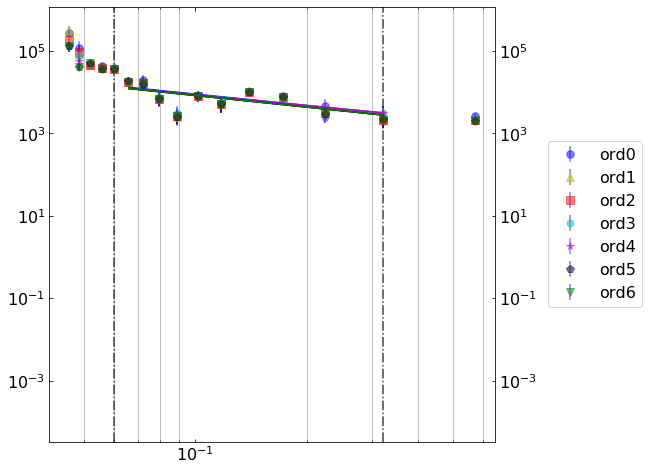

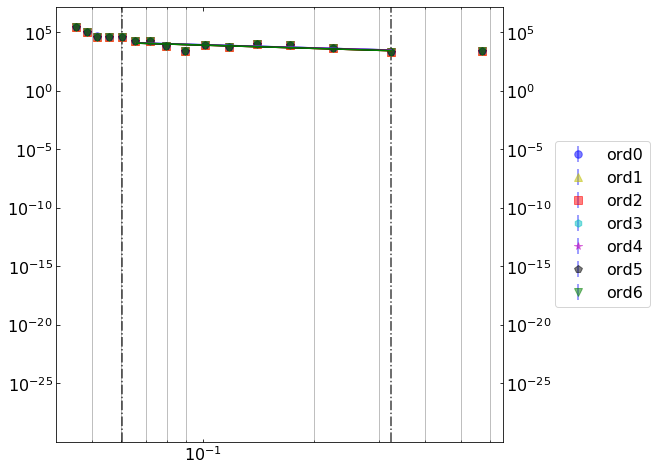

In [46]:
pltdata(PS1k,PS1kPr,xi,xf+1,n)
pltdata(PS2k,PS1kPr,xi,xf+1,n)

1DPSD Turbustat

In [47]:
PST1a=dict()
PST1b=dict()


for i in range(n):
    PST1a[i],PST1b[i]=pst(argo1[i])
    
PST2a=dict()
PST2b=dict()

for i in range(n):
    PST2a[i],PST1b[i]=pst(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/b

In [48]:
for i in range(n):
    print(PST1a[i].slope2D,PST1a[i].slope2D_err)
    


-2.0416205716984765 0.19349767614746538
-1.9469157542222093 0.18258487113117683
-1.9746030094787617 0.18866794986834368
-1.9889922278801693 0.1993345316156645
-2.030960473500398 0.18541313478664878
-2.0924109314700696 0.20555587383267704
-1.9354739270277157 0.1705730769897108


In [49]:
for i in range(n):
    print(PST2a[i].slope2D,PST2a[i].slope2D_err)

-2.0416205716984765 0.19436615169056104
-2.0627875710329726 0.16126759944205904
-2.063557404170032 0.1886679715136257
-1.9163757698139123 0.16707138568957736
-1.6628146524060343 0.20257012725600798
-1.658637025724368 0.2413410311272174
-1.5457660342626676 0.2695944860766327


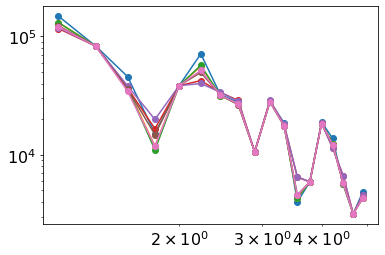

In [50]:
for i in range(n):
    plt.loglog(PST1a[i].wavenumbers,PST1a[i].ps1D,'o-', label=str(i))
    #plt.legend()

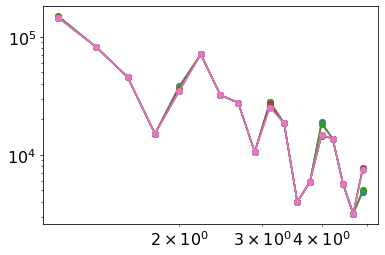

In [51]:
for i in range(n):
    plt.loglog(PST2a[i].wavenumbers,PST2a[i].ps1D,'o-', label=str(i))
    #plt.legend()

In [52]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 192.22042894363403 seconds ---


In [53]:
#SF1

In [54]:
#SF1.to_csv('SF1.csv')